***
# W3: CNN Cancer Detection
***

This project is a submission to [this Kaggle competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview), where I will use a Deep Learning to train Convolutional Neural Network on a set of images to detect metastatic cancer. This is a binary classification problem.

The data is a set of pathology images of tissue samples. Detecting cancerous cells is often very difficult and unreliable, but good machine learning models could potentially save many lives by increasing the rate of detection. The goal of this project is to determine whether there is at least one pixel of cancerous tissue in the central 32x32px section of any tissue sample image.

The data contains 220,025 images for the training data, and 57,458 for the testing data. Each image is 96x96px with 3 8-bit color channels. The data is a cleaned subset of the PCam dataset, which came from the Camelyon16 Challenge. This data came from 2 centers that scanned in many stains of sentinel lymph node sections. The original dataset has been used as a benchmark for many machine learning models.

### Imports

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from PIL import Image
import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import json
from sklearn.utils import shuffle
import glob

%matplotlib inline

***
# Data Exploration and Cleaning
***

In [40]:
base_dir = './data/'
train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')
train_labels = pd.read_csv(os.path.join(base_dir, 'train_labels.csv'))

In [ ]:
print(f"Missing labels: {train_labels['label'].isnull().sum()}")
print(f"Duplicate IDs: {train_labels['id'].duplicated().sum()}")
print("   Unique labels: {train_labels['label'].nunique()}\n")#

sample_ids = train_labels['id'].to_list()
missing_files = 0
corrupted_files = 0

for img_id in sample_ids:
    img_path = os.path.join(train_dir, f'{img_id}.tif')
    
    if not os.path.exists(img_path):
        missing_files += 1
    else:
        try:
            img = Image.open(img_path)
            img.verify()
        except Exception:
            corrupted_files += 1

print(f"Missing/corrupted files: {missing_files + corrupted_files}")

Missing labels: 0
Duplicate IDs: 0
Unique labels: 2

Missing/corrupted files: 0
Missing/corrupted files: 0


The data is quite clean. There are no missing/incorrect labels, and all images are present and readable.

In [4]:
train_labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

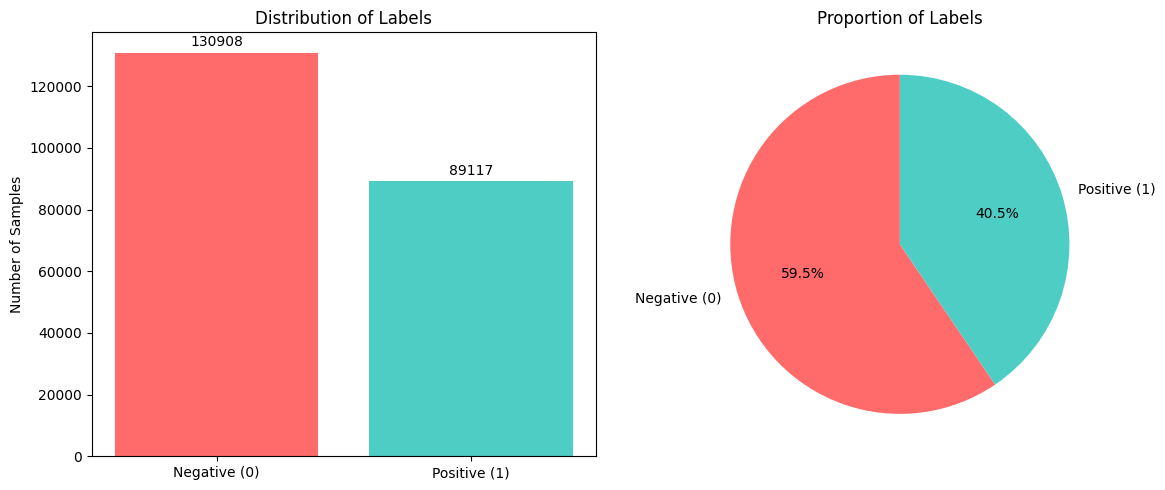

Ratio (Negative:Positive): 1.47:1


In [5]:
label_counts = train_labels['label'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(['Negative (0)', 'Positive (1)'], [label_counts[0], label_counts[1]], 
        color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Distribution of Labels')
ax1.set_ylabel('Number of Samples')
for i, v in enumerate([label_counts[0], label_counts[1]]):
    ax1.text(i, v + 1000, str(v), ha='center', va='bottom')

labels = ['Negative (0)', 'Positive (1)']
sizes = [label_counts[0], label_counts[1]]
colors = ['#FF6B6B', '#4ECDC4']
ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Proportion of Labels')

plt.tight_layout()
plt.show()

total_samples = len(train_labels)
negative_ratio = label_counts[0] / total_samples * 100
positive_ratio = label_counts[1] / total_samples * 100

print(f"Ratio (Negative:Positive): {label_counts[0]/label_counts[1]:.2f}:1")

There is a roughly 3:2 ratio of negative to positive labels. I decided not to worry about this imbalance as it was within an acceptable range, and shouldn't affect the training too much.

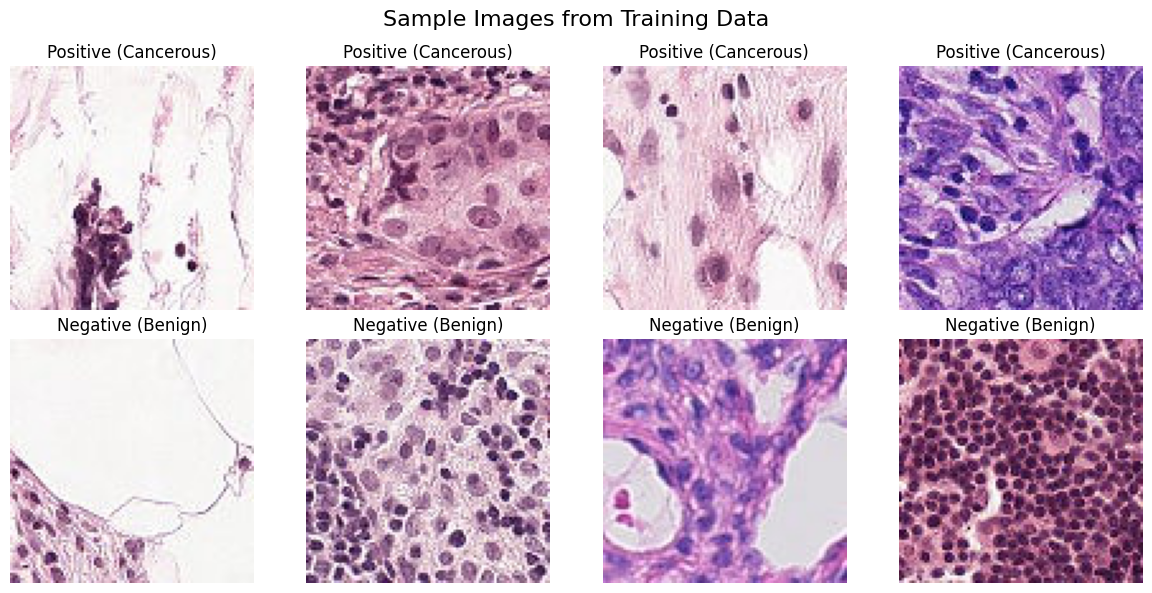

In [6]:
positive_samples = train_labels[train_labels['label'] == 1]['id'].head(4).values
negative_samples = train_labels[train_labels['label'] == 0]['id'].head(4).values

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Sample Images from Training Data', fontsize=16)

for i, img_id in enumerate(positive_samples):
    img_path = os.path.join(train_dir, f'{img_id}.tif')
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Positive (Cancerous)')
    axes[0, i].axis('off')

for i, img_id in enumerate(negative_samples):
    img_path = os.path.join(train_dir, f'{img_id}.tif')
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Negative (Benign)')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

A basic visual comparison of a few different positive and negative samples doesn't make the distinction between the two very clear, but some of the statistics below help make it more clear.

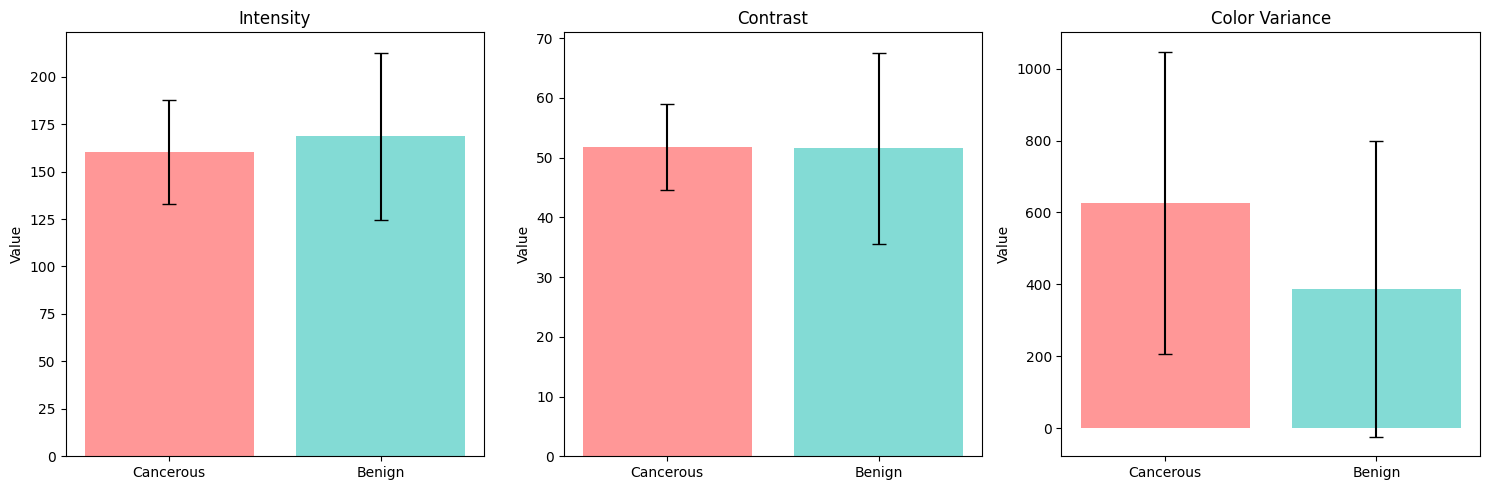

In [23]:
sample_positive = train_labels[train_labels['label'] == 1]['id'].values
sample_negative = train_labels[train_labels['label'] == 0]['id'].values

def analyze_images(image_ids):
    intensities = []
    contrasts = []
    color_variances = []
    
    for img_id in image_ids:
        try:
            img_path = os.path.join(train_dir, f'{img_id}.tif')
            img = np.array(Image.open(img_path))
            
            intensities.append(np.mean(img))
            
            contrasts.append(np.std(img))
            
            color_var = np.var([np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])])
            color_variances.append(color_var)
            
        except Exception as e:
            continue
    
    return {
        'mean_intensity': np.mean(intensities),
        'std_intensity': np.std(intensities),
        'mean_contrast': np.mean(contrasts),
        'std_contrast': np.std(contrasts),
        'mean_color_variance': np.mean(color_variances),
        'std_color_variance': np.std(color_variances)
    }

pos_stats = analyze_images(sample_positive)
neg_stats = analyze_images(sample_negative)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

categories = ['Intensity', 'Contrast', 'Color Variance']
pos_values = [pos_stats['mean_intensity'], pos_stats['mean_contrast'], pos_stats['mean_color_variance']]
neg_values = [neg_stats['mean_intensity'], neg_stats['mean_contrast'], neg_stats['mean_color_variance']]
pos_errors = [pos_stats['std_intensity'], pos_stats['std_contrast'], pos_stats['std_color_variance']]
neg_errors = [neg_stats['std_intensity'], neg_stats['std_contrast'], neg_stats['std_color_variance']]

for i, (category, pos_val, neg_val, pos_err, neg_err) in enumerate(zip(categories, pos_values, neg_values, pos_errors, neg_errors)):
    axes[i].bar(['Cancerous', 'Benign'], [pos_val, neg_val], 
                yerr=[pos_err, neg_err], capsize=5,
                color=['#FF6B6B', '#4ECDC4'], alpha=0.7)
    axes[i].set_title(f'{category}')
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

These three metrics give a little more information on how the samples can be better classified.

**Intensity (Brightness):**
- Measures the average pixel brightness across the entire image
- Calculated as the mean of all RGB pixel values (0-255 scale)
- Higher values = brighter/lighter images, lower values = darker images

**Contrast:**
- Measures the variation in pixel intensities within an image
- Calculated as the standard deviation of all pixel values
- Higher values mean more variation between light and dark areas
- Lower values mean more uniform lighting

**Color Variance:**
- Measures how much the three color channels differ from each other on average
- Calculated as the variance between the mean values of each RGB channel
- Higher values mean more color diversity/imbalance between channels
- Lower values mean more neutral/balanced coloring

The intensity and contrast are similar, but the deviation of benign samples is slightly larger than cancerous ones. The color variance is much different between the two classes, but the deviation for both of them is quite high.

These statistics can show a distinct difference between types of samples that are not easily detected visually.

### Analysis

Based off the exploration, I believe the data will be good to train with mostly as is. There is variance in some statistics, and the class imbalance is not too bad. 

Because of the high range of values for each pixel (3 values from 0-255), I will be normalizing the data. There will also be batch normalization included, but that will be discussed in the architecture section.

Despite the extra large image size vs what area we need to detect cancerous cells in, I decided not to reduce the size of the images, as the surrounding areas could contain patterns that were not cancerous themselves, but indicative of nearby cancer cells.

### Metrics

I will be using the AUC-ROC score (Area Under the ROC Curve) to measure the performance of my models, as that is the metric used for the Kaggle competition. The metric is also good for binary classification problems, as it can be a clear metric of how well the model can discriminate between samples while also taking into account imbalances.

The AUC score accounts for class imbalances by also incorporating the true positive rate and the false positive rate. Both of these are important in this case, as while detecting cancer in the early stages can help save many lives, undergoing uneccessary cancer treatment is also very harmful.

***
# Modelling
***

*The actual modelling in this section was done in Google Colab in order to access its high-end GPUs. The code run there is still in this notebook, but they weren't run here. The performance data from the models is loaded through JSON files.*

### Architecture

For this project, I have decided to use a **conv-conv-maxpool** CNN architecture consisting of paired convolution layers followed by max pooling to progressively extract features and reduce the data size. The model begins with 32 filters and doubles them in each subsequent block (32, 64, 128, 256), enabling the network to learn simpler features initially before progressing to more complex cancerous patterns. I experimented with the number of layers as well.

Since the goal of this model is to detect even a single cancerous pixel, I kept 2 convolution layers per block in order to detect minute patterns better. The increasing number of filters will help detect features of varying size, from individual cell boundaries to larger tissue structures.

This architecture also doesn't introduce unneccessary complexity such as with ResNet and DenseNet, which may be too deep for this kind of data and end up overfitting.

To prevent overfitting, I used **batch normalization** and **dropout layers**. Batch normalization addresses the inherent variability in medical images due to differences in staining protocols and preparation methods. Dropout layers (25% after convolutional blocks, 50% in dense layers) prevents overfitting to specific types of images without reducing the overall accuracy.

In [14]:
# Model Configuration
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 15
VALIDATION_SPLIT = 0.2

Batch loading the data was done for memory efficiency and performance.

In [51]:
class CancerImageDataLoader:
    def __init__(self, df, img_dir, batch_size=32, validation_split=0.2):
        self.df = df
        self.img_dir = img_dir
        self.batch_size = batch_size
        
        shuffled_df = shuffle(df, random_state=42)
        split_idx = int(len(shuffled_df) * (1 - validation_split))
        
        self.train_df = shuffled_df[:split_idx].reset_index(drop=True)
        self.val_df = shuffled_df[split_idx:].reset_index(drop=True)
        
        self.train_steps = len(self.train_df) // batch_size
        self.val_steps = len(self.val_df) // batch_size
        
        print(f"Training samples: {len(self.train_df)}")
        print(f"Validation samples: {len(self.val_df)}")
        print(f"Training steps per epoch: {self.train_steps}")
    
    def load_and_preprocess_image(self, img_id, label):
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        try:
            img = Image.open(img_path)
            img_array = np.array(img, dtype=np.float32) / 255.0  # normalize to [0,1]
            return img_array, label
        except Exception:
            return np.zeros((96, 96, 3), dtype=np.float32), label
    
    def batch_generator(self, df, shuffle_data=True):
        while True:
            if shuffle_data:
                df = df.sample(frac=1, random_state=None).reset_index(drop=True)
            
            for start_idx in range(0, len(df), self.batch_size):
                end_idx = min(start_idx + self.batch_size, len(df))
                batch_df = df.iloc[start_idx:end_idx]
                
                batch_images = []
                batch_labels = []
                
                for _, row in batch_df.iterrows():
                    img, label = self.load_and_preprocess_image(row['id'], row['label'])
                    batch_images.append(img)
                    batch_labels.append(label)
                
                yield np.array(batch_images), np.array(batch_labels)
    
    def get_generators(self):
        train_gen = self.batch_generator(self.train_df, shuffle_data=True)
        val_gen = self.batch_generator(self.val_df, shuffle_data=False)
        return train_gen, val_gen

In [52]:
def create_cancer_cnn_model(input_shape=(96, 96, 3), learning_rate=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # classifier
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )
    
    return model

In [53]:
def create_simple_cancer_cnn_model(input_shape=(96, 96, 3), learning_rate=0.001, adam=True):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        # classifier
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    
    if adam:
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )
    
    return model

### Hyperparameter Tuning

I kept some parameters as-is, as they generally perform well for this kind of data. This includes a **ReLU** activation function for the hidden layers, a **sigmoid** activation function for the output layer (good for binary classification), 3x3 filters, even padding, and **Adam** for the optimization method.

I tuned other parameters such as learning rate, hidden layer count, dropout layers, and batch size, with the results shown in the modelling process below.

In [54]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_cancer_model.h5',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

These callbacks also optimize the training process.

**EarlyStopping** automatically stops the training process at some epoch if the (in this case) validation loss doesn't decrease by a certain amount. This prevents the model from overfitting and wasting time on unneccessary training.

**ReduceLROnPlateau** monitors the validation loss when training and detects when it stops improving for a certain amount of epochs. When this happens, it cuts the learning rate in half, allowing the model to fine-tune its parameters better. It also can help it from bouncing around an optimal model when the learning rate is too high. This interacts with the EarlyStopping callback by fine-tuning the model further before ending the training at an optimal point.

**ModelCheckpoint** saves the best model version after training is completed to a file.

In [55]:
def plot_training_history(history, simple=False):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # loss
    axes[0, 0].plot(history['loss'], label='Training Loss')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # accuracy
    axes[0, 1].plot(history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # AUC
    axes[1, 0].plot(history['AUC'], label='Training AUC')
    axes[1, 0].plot(history['val_AUC'], label='Validation AUC')
    axes[1, 0].set_title('Model AUC-ROC')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    
    # precision
    axes[1, 1].plot(history['Precision'], label='Training Precision')
    axes[1, 1].plot(history['val_Precision'], label='Validation Precision')
    axes[1, 1].set_title('Model Precision')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Epochs: {EPOCHS}")
    print(f"Architecture version: {'Simple' if simple else 'Complex'}")

    print("\nResults:")
    print(f"Loss: {history['val_loss'][-1]:.4f}")
    print(f"Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Training AUC-ROC: {history['AUC'][-1]:.4f}")
    print(f"Validation AUC-ROC: {history['val_AUC'][-1]:.4f}")

## Model 1

The first model uses:
- a learning rate of 0.001
- a batch size of 32
- 15 epochs

In [ ]:
model = create_cancer_cnn_model(learning_rate=LEARNING_RATE)

model.summary()

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,04

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,04

 Total params: 6,026,913 (22.99 MB)

 Trainable params: 6,024,929 (22.98 MB)

 Non-trainable params: 1,984 (7.75 KB)


Model Configuration:
Learning Rate: 0.001
Optimizer: Adam
Batch Size: 32
Epochs: 15


In [ ]:
data_loader = CancerImageDataLoader(
    train_labels, 
    train_dir, 
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT
)

train_generator, val_generator = data_loader.get_generators()

Training samples: 176020
Validation samples: 44005
Training steps per epoch: 5500


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=data_loader.train_steps,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=data_loader.val_steps,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed")

In [9]:
# load history from file
with open('history1.json', 'r') as f:
    history1 = json.load(f)

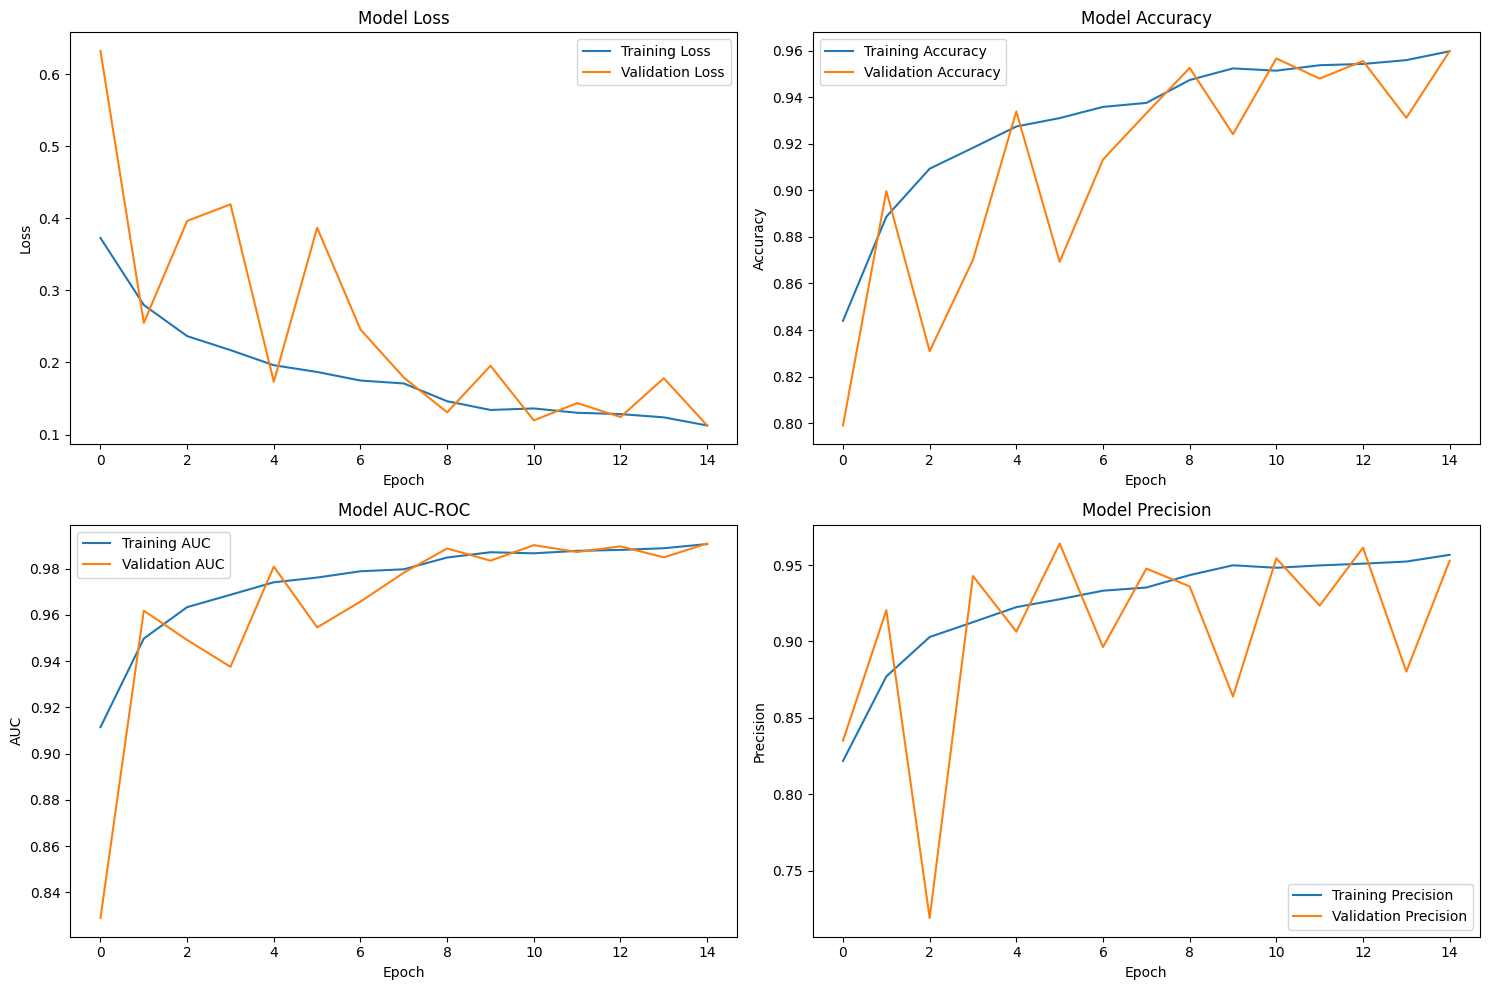

Learning Rate: 0.01
Batch Size: 32
Epochs: 15
Architecture version: Complex

Results:
Loss: 0.1126
Accuracy: 0.9599
Training AUC-ROC: 0.9906
Validation AUC-ROC: 0.9908


In [23]:
plot_training_history(history1)

This base model already had great results, with no indication of overfitting and a high AUC-ROC.

## Model 2

I increased the learning rate by a factor of 10 to see how it would influence the model's performance.

In [ ]:
LEARNING_RATE = 0.01
model2 = create_cancer_cnn_model(learning_rate=LEARNING_RATE)

In [ ]:
model2 = create_cancer_cnn_model(learning_rate=LEARNING_RATE)

history2 = model2.fit(
    train_generator,
    steps_per_epoch=data_loader.train_steps,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=data_loader.val_steps,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

In [19]:
with open('history2.json', 'r') as f:
    history2 = json.load(f)

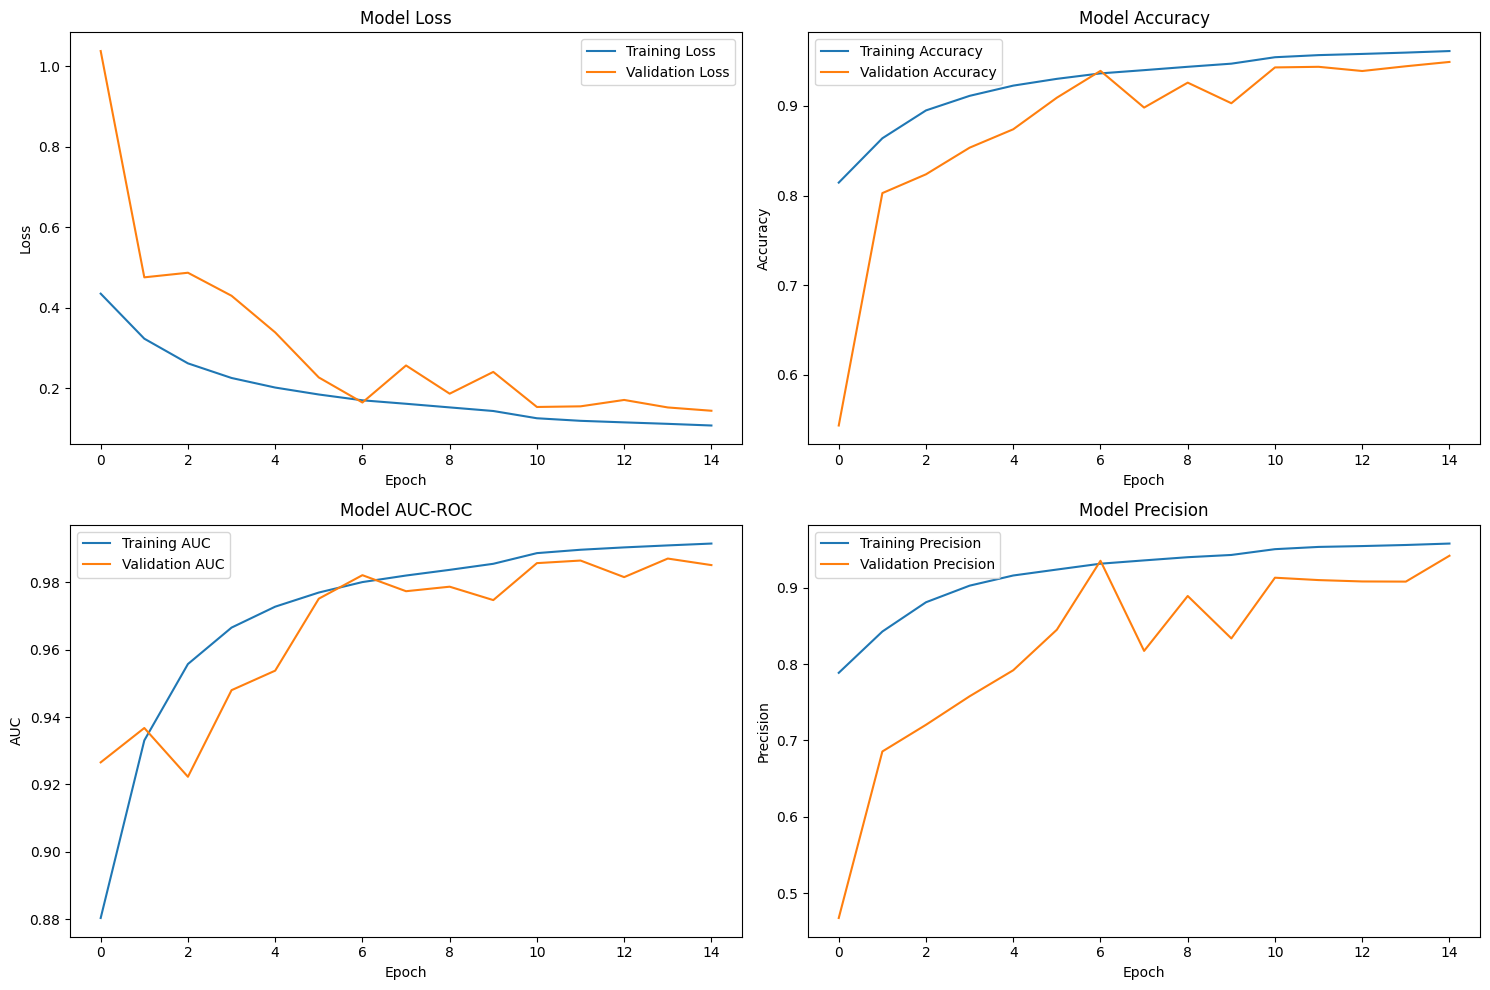

Learning Rate: 0.001
Batch Size: 32
Epochs: 20
Architecture version: Complex

Results:
Loss: 0.1446
Accuracy: 0.9491
Training AUC-ROC: 0.9915
Validation AUC-ROC: 0.9851


In [47]:
plot_training_history(history2)

While training loss and AUC-ROC had similar performance as before, the validation scores were  more varied throughout the training process, with lower scores for the fully trained model. This likely indicates that the learning rate was too fast, and was bouncing around the minimum loss model with too large steps.

## Model 3

For the third model, I went back to the original learning rate since it had very similar training and validation scores. I increased the batch size significantly to try and speed up the learning process. I also increased the number of epochs.

In [26]:
LEARNING_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 20

In [ ]:
data_loader = CancerImageDataLoader(
    train_labels, 
    train_dir, 
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT
)

train_generator, val_generator = data_loader.get_generators()

In [ ]:
model3 = create_cancer_cnn_model(learning_rate=LEARNING_RATE)

history3 = model3.fit(
    train_generator,
    steps_per_epoch=data_loader.train_steps,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=data_loader.val_steps,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

In [27]:
with open('history3.json', 'r') as f:
    history3 = json.load(f)

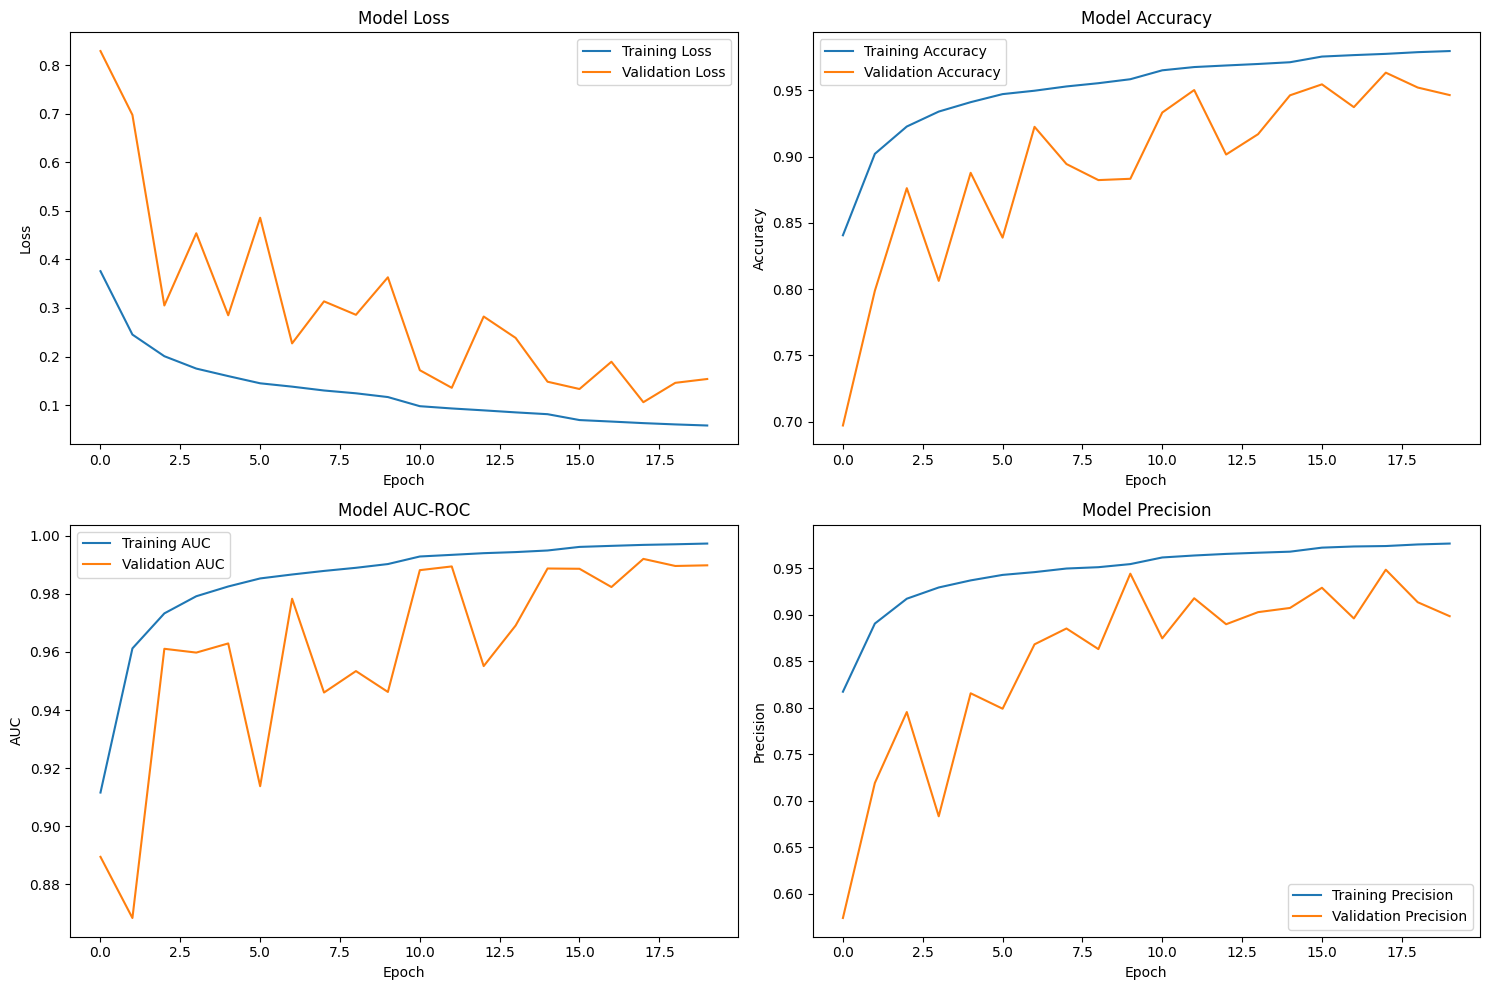

Learning Rate: 0.001
Batch Size: 256
Epochs: 20
Architecture version: Complex

Results:
Loss: 0.1537
Accuracy: 0.9464
Training AUC-ROC: 0.9973
Validation AUC-ROC: 0.9898


In [28]:
plot_training_history(history3)

This model performed even more wildly than the second one. The variation in scores between epochs is much larger. This is likely because the increased batch size made the weight updates more coarse-grained, since more data is used per update. This would result in larger steps made towards/around the optimal model.

## Model 4

This model had a simpler architecture, using only 3 blocks of conv-conv-maxpool, with less dropout per layer. The final convolution block has 128 filters per layer.

This could potentially reduce overfitting just by being simpler. The training time will also be much faster, and the reduced dropout could potentially allow the gradient to converge faster.

However, this could become oversimplified and too general, not being able to see more detailed cancerous patterns.

In [48]:
LEARNING_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 20

In [ ]:
data_loader = CancerImageDataLoader(
    train_labels, 
    train_dir, 
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT
)

train_generator, val_generator = data_loader.get_generators()

In [1]:
model4 = create_simple_cancer_cnn_model(learning_rate=LEARNING_RATE)

history4 = model4.fit(
    train_generator,
    steps_per_epoch=data_loader.train_steps,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=data_loader.val_steps,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

In [30]:
with open('history4.json', 'r') as f:
    history4 = json.load(f)

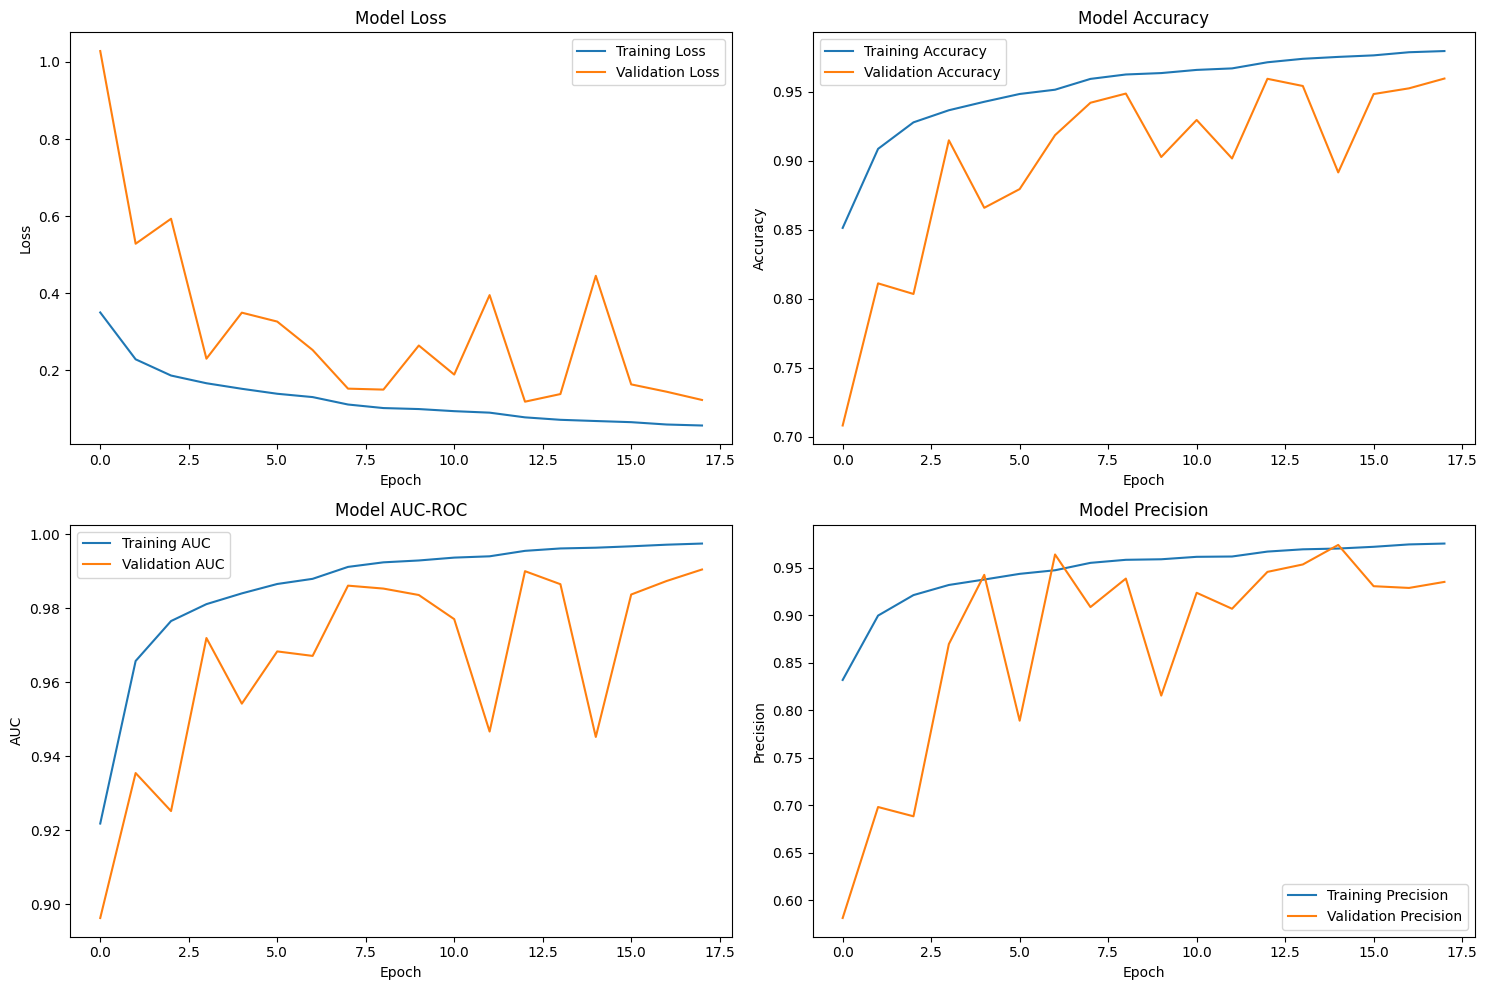

Learning Rate: 0.001
Batch Size: 256
Epochs: 20
Architecture version: Simple

Results:
Loss: 0.1234
Accuracy: 0.9596
Training AUC-ROC: 0.9975
Validation AUC-ROC: 0.9905


In [49]:
plot_training_history(history4, simple=True)

While this model had similar overall performance, the slightly larger gap in training and validation scores may indicate some overfitting or a lack of convergence. The validation scores varied quite a bit here too. This may be due to the high batch size, compounded by the simpler architecture being more general in its learning. Like before, the high batch size decreased the training steps per epoch, leading to less fine-grained tuning.

## Model 5

The next few models further experimented with the architecture types and batch sizes.

This one used the complex architecture with a medium batch size.

In [57]:
BATCH_SIZE = 128

In [ ]:
data_loader = CancerImageDataLoader(
    train_labels, 
    train_dir, 
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT
)

train_generator, val_generator = data_loader.get_generators()

model5 = create_cancer_cnn_model(learning_rate=LEARNING_RATE)

history5 = model5.fit(
    train_generator,
    steps_per_epoch=data_loader.train_steps,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=data_loader.val_steps,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

In [45]:
with open('history5.json', 'r') as f:
    history5 = json.load(f)

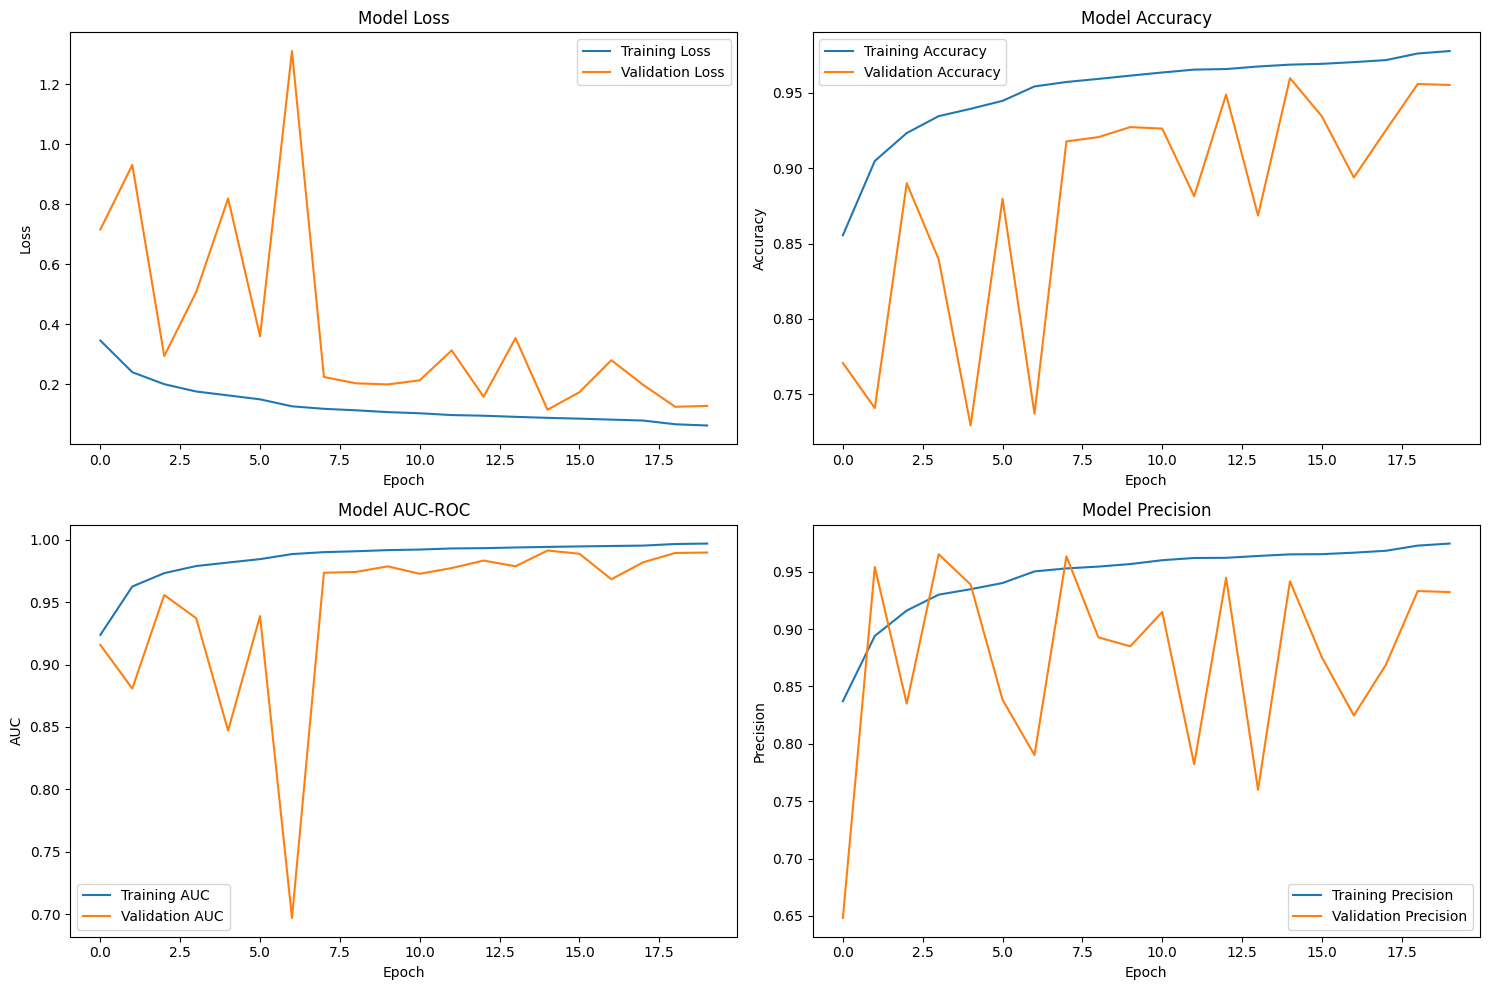

Learning Rate: 0.001
Batch Size: 128
Epochs: 20
Architecture version: Complex

Results:
Loss: 0.1282
Accuracy: 0.9553
Training AUC-ROC: 0.9968
Validation AUC-ROC: 0.9896


In [58]:
plot_training_history(history5)

This model performed quite well. The validation and training scores were slightly closer than the than model 2 and 3, with quicker convergence. The reduced batch size likely helped the scores improve more stably by having more update steps per epoch. However, model precision seems to be lower than other models.

## Model 6

This model uses the simple architecture with a medium batch size.

In [59]:
BATCH_SIZE = 128

In [ ]:
data_loader = CancerImageDataLoader(
    train_labels, 
    train_dir, 
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT
)

train_generator, val_generator = data_loader.get_generators()

model6 = create_cancer_cnn_model(learning_rate=LEARNING_RATE)

history6 = model6.fit(
    train_generator,
    steps_per_epoch=data_loader.train_steps,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=data_loader.val_steps,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

In [60]:
with open('history6.json', 'r') as f:
    history6 = json.load(f)

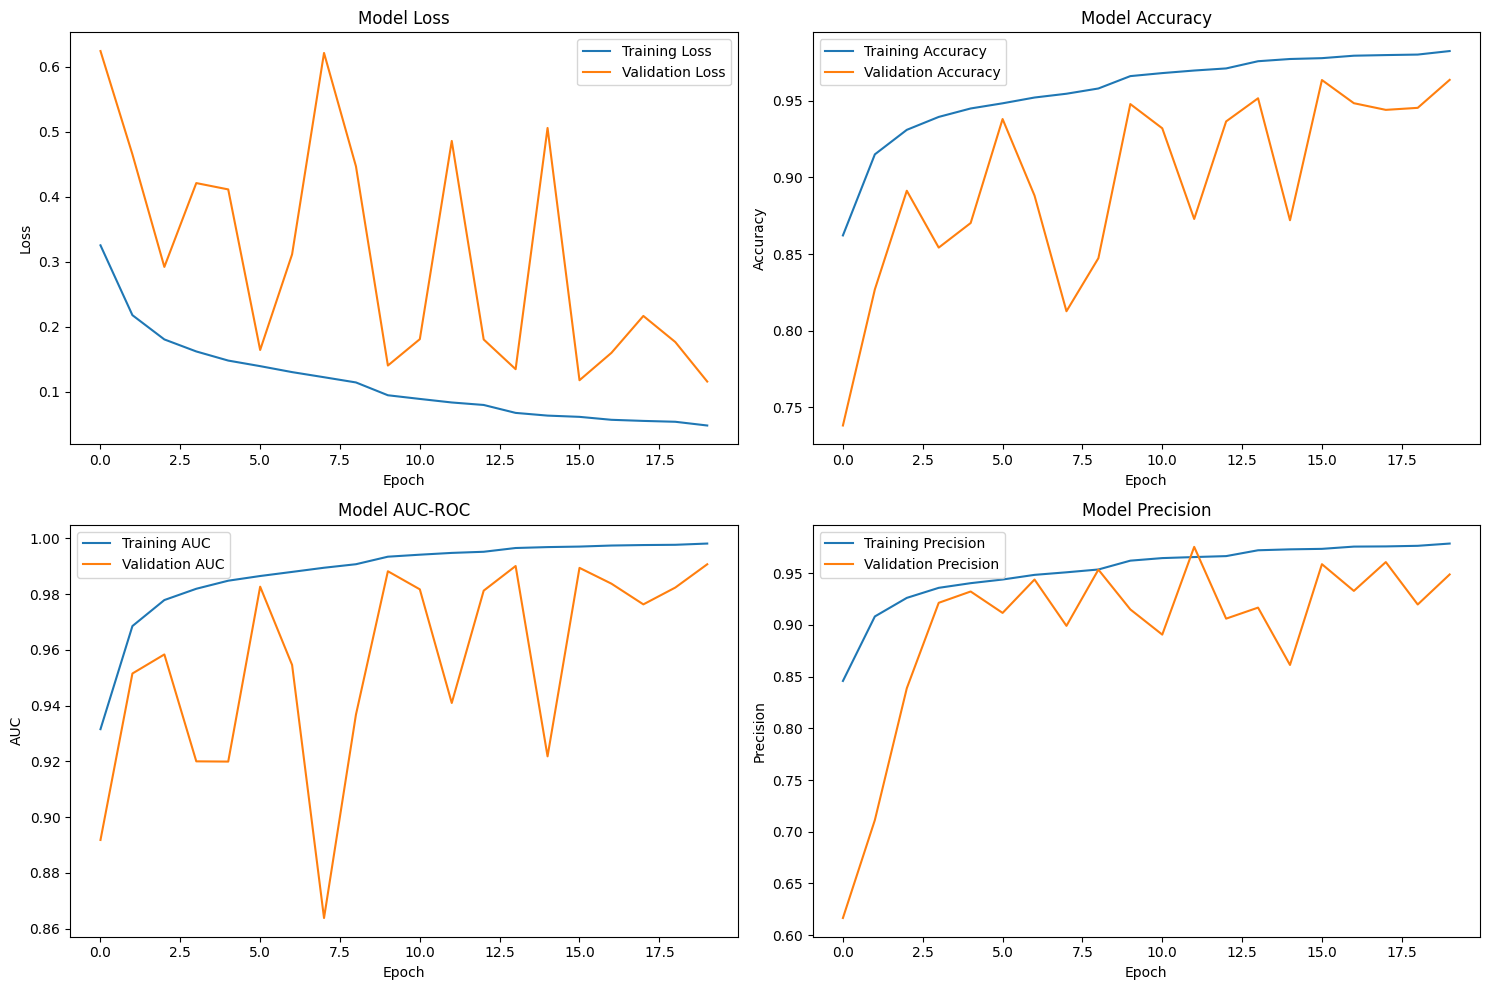

Learning Rate: 0.001
Batch Size: 128
Epochs: 20
Architecture version: Simple

Results:
Loss: 0.1154
Accuracy: 0.9638
Training AUC-ROC: 0.9982
Validation AUC-ROC: 0.9907


In [61]:
plot_training_history(history6, simple=True)

This model had great scores, but a slightly larger gap in validation and training scores, indicating slight overfitting. The high variance is likely because of the high batch size, as seen in how the validation scores don't converge well.

## Model 7

This model uses the small batch size with the simple architecture.

In [34]:
BATCH_SIZE = 32

In [ ]:
data_loader = CancerImageDataLoader(
    train_labels, 
    train_dir, 
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT
)

train_generator, val_generator = data_loader.get_generators()

model7 = create_simple_cancer_cnn_model(learning_rate=LEARNING_RATE)

history7 = model7.fit(
    train_generator,
    steps_per_epoch=data_loader.train_steps,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=data_loader.val_steps,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

In [35]:
with open('history7.json', 'r') as f:
    history7 = json.load(f)

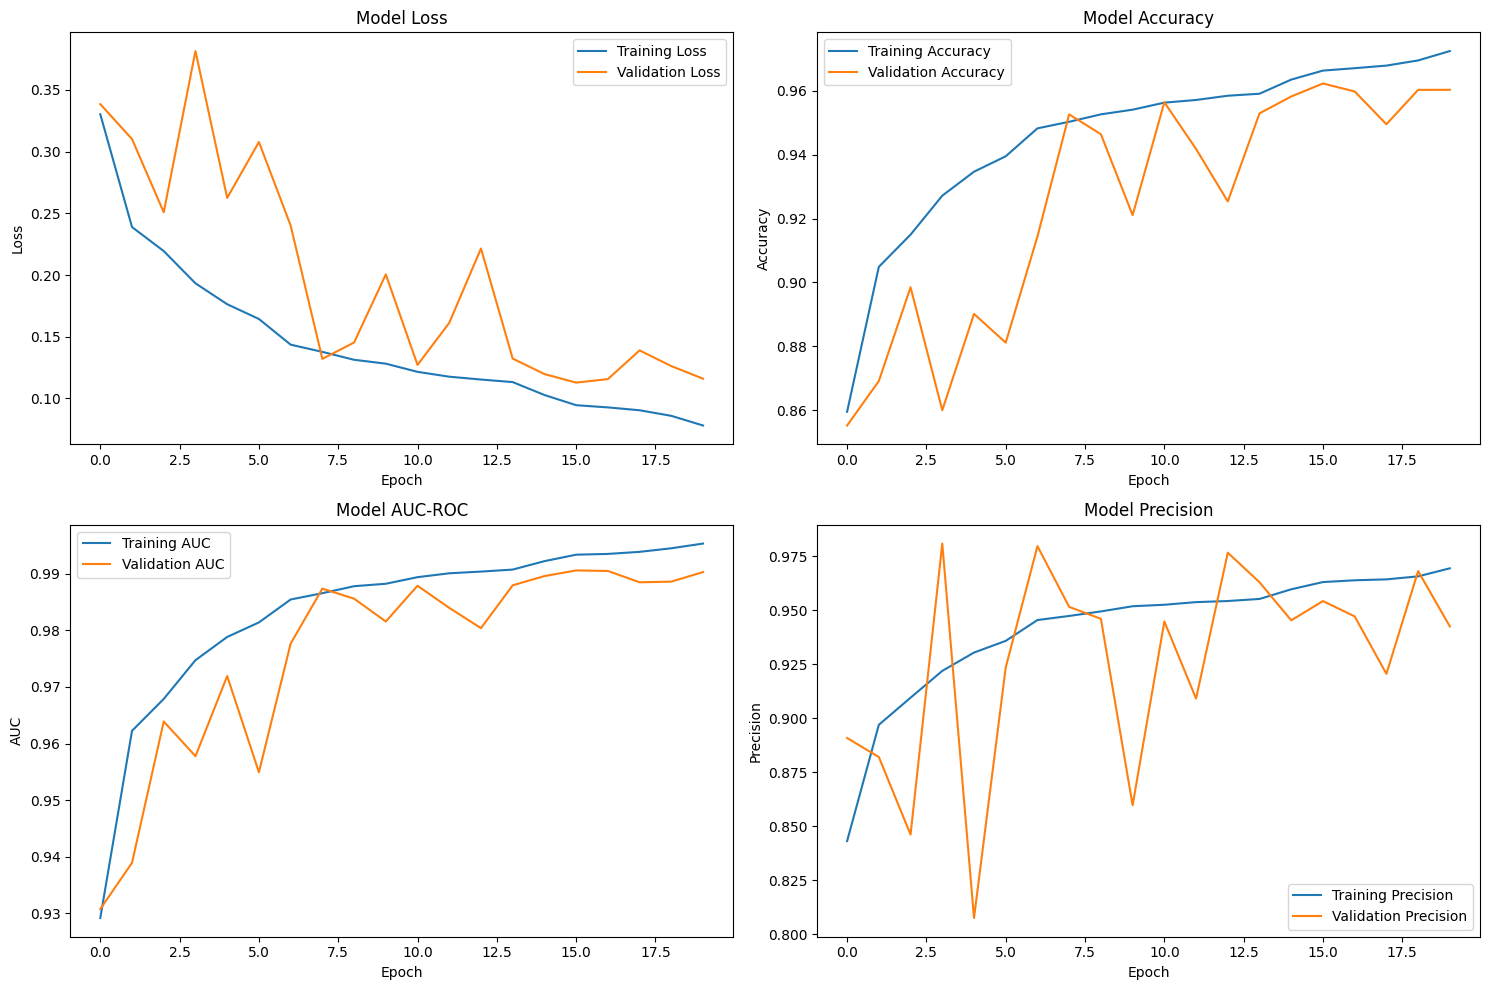

Learning Rate: 0.001
Batch Size: 32
Epochs: 20
Architecture version: Simple

Results:
Loss: 0.1160
Accuracy: 0.9603
Training AUC-ROC: 0.9953
Validation AUC-ROC: 0.9903


In [37]:
plot_training_history(history7, simple=True)

The small batch sizes seem to perform best overall, especially in this model. The simple architecture also doesn't hold the model back, showing that the extra complexity isn't needed.  
The validation scores also converge stably, demonstrating a good fit without overfitting.

***
# Results and Conclusions
***

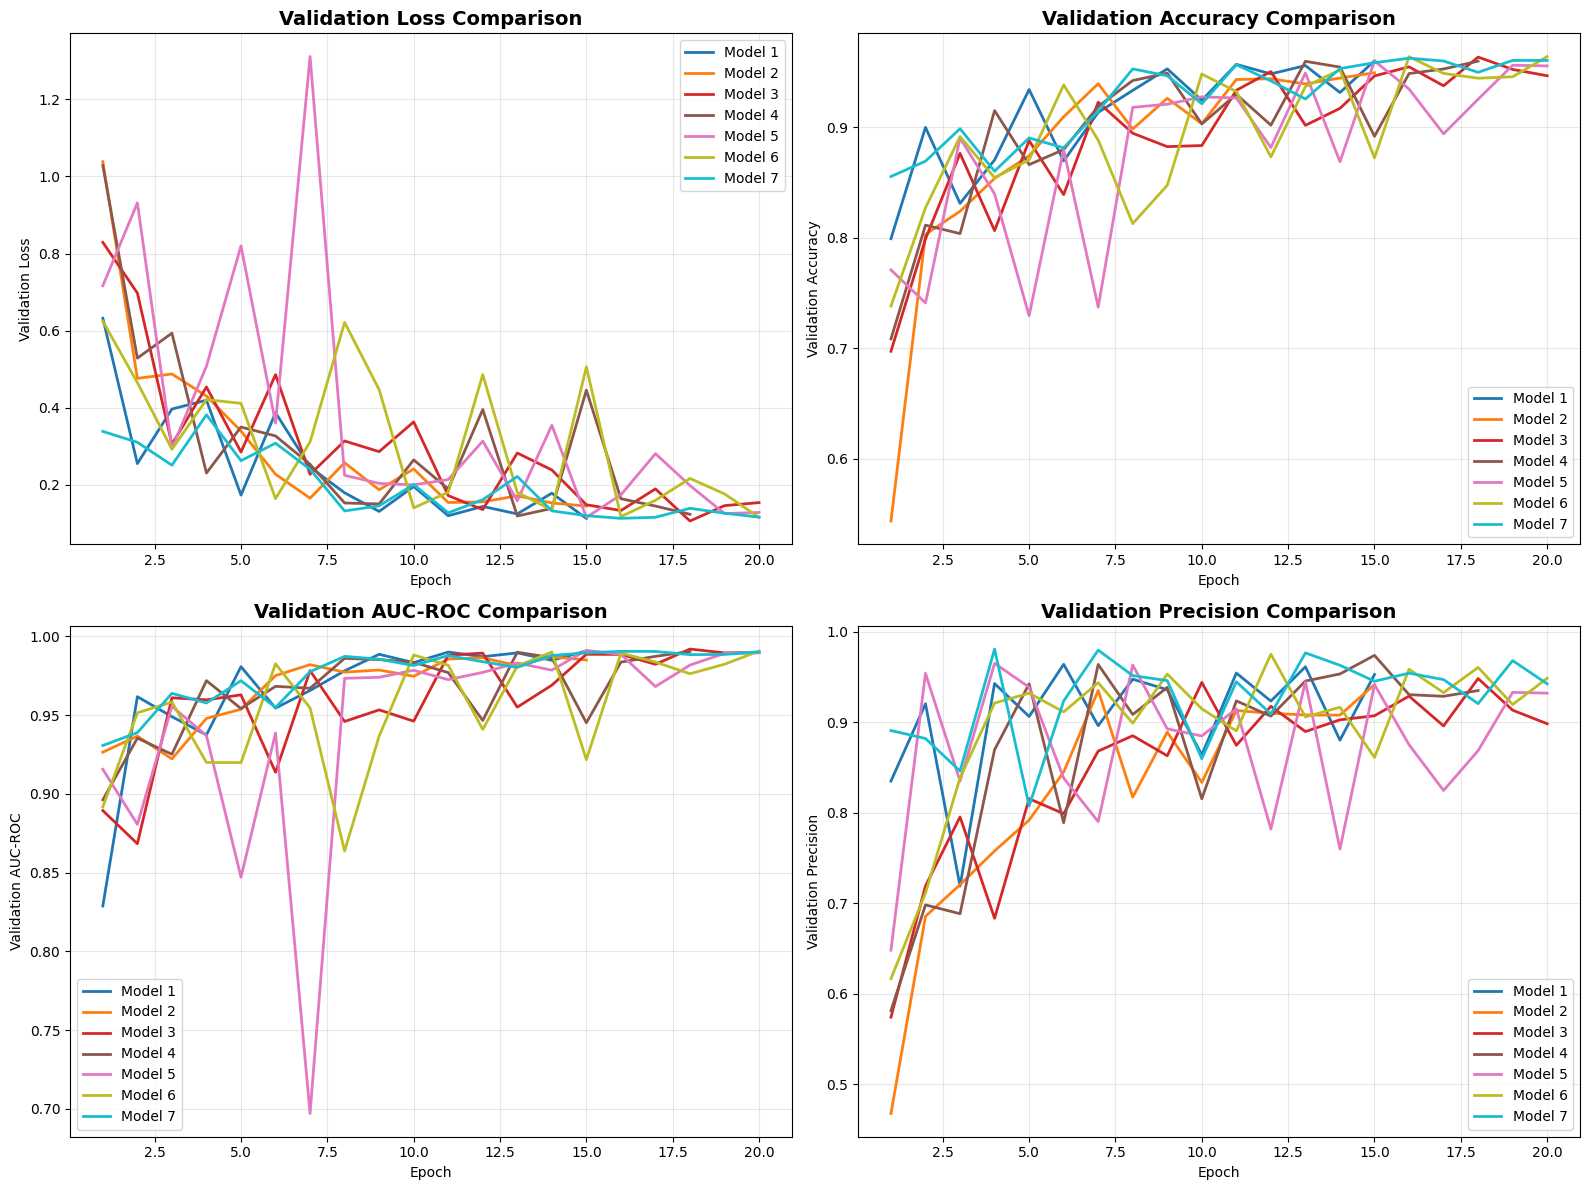

In [65]:
model_configs = {
    'Model 1': {'LR': 0.001, 'BS': 32, 'Arch': 'Complex'},
    'Model 2': {'LR': 0.01, 'BS': 32, 'Arch': 'Complex'},
    'Model 3': {'LR': 0.001, 'BS': 256, 'Arch': 'Complex'},
    'Model 4': {'LR': 0.001, 'BS': 256, 'Arch': 'Simple'},
    'Model 5': {'LR': 0.001, 'BS': 128, 'Arch': 'Complex'},
    'Model 6': {'LR': 0.001, 'BS': 128, 'Arch': 'Complex'},
    'Model 7': {'LR': 0.001, 'BS': 32, 'Arch': 'Simple'}
}

histories = [history1, history2, history3, history4, history5, history6, history7]
model_names = list(model_configs.keys())

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = plt.cm.tab10(np.linspace(0, 1, 7))

ax1 = axes[0, 0]
for i, (history, model_name) in enumerate(zip(histories, model_names)):
    epochs = range(1, len(history['val_loss']) + 1)
    ax1.plot(epochs, history['val_loss'], label=model_name, color=colors[i], linewidth=2)
ax1.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
for i, (history, model_name) in enumerate(zip(histories, model_names)):
    epochs = range(1, len(history['val_accuracy']) + 1)
    ax2.plot(epochs, history['val_accuracy'], label=model_name, color=colors[i], linewidth=2)
ax2.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
for i, (history, model_name) in enumerate(zip(histories, model_names)):
    epochs = range(1, len(history['val_AUC']) + 1)
    ax3.plot(epochs, history['val_AUC'], label=model_name, color=colors[i], linewidth=2)
ax3.set_title('Validation AUC-ROC Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Validation AUC-ROC')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
for i, (history, model_name) in enumerate(zip(histories, model_names)):
    epochs = range(1, len(history['val_Precision']) + 1)
    ax4.plot(epochs, history['val_Precision'], label=model_name, color=colors[i], linewidth=2)
ax4.set_title('Validation Precision Comparison', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Validation Precision')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Ultimately, I chose model 7 for its quick and stable convergence, as well as high top performing train and validation scores. in all 4 metrics

### Competition Results

In [43]:
def load_and_predict(model_name, output_name):
    model = load_model(model_name)
    test_files = glob.glob(os.path.join(test_dir, '*.tif'))
    test_ids = []
    predictions = []
    batch_size = 32
    test_images = []
    current_ids = []

    for i, file_path in enumerate(test_files):
        img_id = os.path.basename(file_path).replace('.tif', '')
        
        try:
            img = Image.open(file_path)
            img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
            
            test_images.append(img_array)
            current_ids.append(img_id)
            
            # process in batches
            if len(test_images) == batch_size or i == len(test_files) - 1:
                batch_images = np.array(test_images)
                batch_predictions = model.predict(batch_images, verbose=0)
                
                binary_predictions = (batch_predictions.flatten() > 0.5).astype(int)
                
                test_ids.extend(current_ids)
                predictions.extend(binary_predictions)
                
                test_images = []
                current_ids = []
        
        except Exception as e:
            print(f"Error processing {img_id}: {e}")
            continue

    submission_df = pd.DataFrame({
        'id': test_ids,
        'label': predictions
    })

    submission_df.to_csv(output_name, index=False)

In [ ]:
load_and_predict('first_down_model.h5', 'cancer_predictions.csv')

This is the result for model 7, using a small batch size, moderate learning rate, and simpler architecture.

![Screenshot 2025-11-30 122104.png](<attachment:Screenshot 2025-11-30 122104.png>)
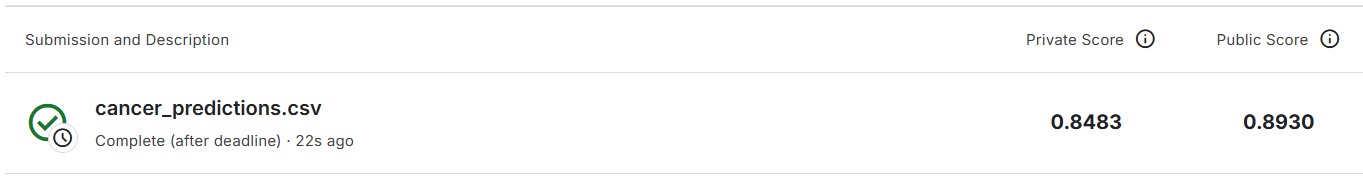

The final accuracy on the test data had decent results, with a public score of 0.893.

### Hyperparameter Optimization Procedure Summary

Ultimately, my procedure for tuning the hyperparameters mainly involved adjusting each individual parameter to find the right value, then moving on the next parameter with the optimized values from before. While not as exhaustive as a grid search, this still found good parameters to use for the final model.

### Conclusion

The final combination of parameters that made the best model were:
- a learning rate of 0.001
- simpler architecture
- batch size of 32
- 20 epochs

The medium/small learning rate did well, as my model ended up converging at a stable pace without too much jumping around for both training and validation scores.  
High learning rates would cause larger steps per weight update, causing the model to potentially miss the lowest loss point repeatedly by jumping around it. This medium learning rate was good because it converged quickly, but the callback functions which reduced learning rate at certain points allowed the model to fine-tune its weights near the end of the training process.

The smaller batch sizes ended up being better everytime. This is likely because it allowed the model to take more steps per epoch, or update its weights more frequently. The changes in this parameter are similar in concept to the learning rate, where it could either learn too quickly or slowly.

The simpler architecture ended up performing very similarly to them more complex architecture. I ended up choosing the simpler one, as it is generally recommended. This is because more complex models are more prone to overfitting, so if a simpler one suffices, it should be used instead. Simpler models also use less resources to train and use.

### Takeaways and Further Steps

As this was my first time training a NN model, seeing how the different parameters affected performance in real time was very interesting. Memory management was also very important, and batch loading the data was vital to be able to train in a timely manner without errors.

If I had more time to work on this model, I would like to run some kind of grid search on the hyperparameters. Because of time constraints, I had to tune parameters one at a time. With a grid search, I could test every possible combination of parameters I selected, giving a more comprehensive picture of how the parameters interact with eachother.

### References

“Histopathologic Cancer Detection.”  
Kaggle, www.kaggle.com/c/histopathologic-cancer-detection/overview.

*AI Use/Citation:*

Github Copilot (Claude) was used during the development of this project. It's use was limited to:
- syntax correction/improvement
- code suggestions for small operations
- improving formatting of code
- nicely formatting print statements and statistics
- suggesting certain functions for plots I was trying to make
- making plots look and scale better

All ideas for every step of the project came from me.